# Entity Co-occurrence Graph Analysis

This notebook analyses and compares the different graphs created using the FEL and DBpedia Spotlight algorithms. In the interest of space, the associated paper only analyses FEL graphs with -2 to -3 confidence and DBpedia Spotlight graphs with 0.5 to 0.9 confidence, but other graphs are also possible.

In [1]:
from graph_tool import Graph
import graph_tool.all as gt
import pandas as pd
from itertools import combinations
from matplotlib import pyplot as plt
import numpy as np
from collections import Counter
from itertools import zip_longest
import ast
import pickle

In [2]:
def get_main_graph_prop(g):
    num_vertices = g.num_vertices()
    num_edges = g.num_edges()
    average_degree = num_edges/num_vertices
    
    weighted_degree_arr = g.get_total_degrees(g.get_vertices(), eweight = g.edge_properties['weight'])
    average_weighted_degree = weighted_degree_arr.sum()/num_vertices

    u = gt.extract_largest_component(g)
    size_largest_comp = u.num_vertices()

    pd, ep = gt.pseudo_diameter(g)

    return num_vertices, num_edges, pd, average_degree, average_weighted_degree, size_largest_comp

def calc_ave_graph_values(g):
    local_clust = gt.vertex_average(g, gt.local_clustering(g))
    global_clust = gt.global_clustering(g)
    weighted_assort = gt.assortativity(g, "total", eweight = g.edge_properties['weight'])
    unweighted_assort = gt.assortativity(g, "total")

    return local_clust, global_clust, weighted_assort, unweighted_assort

def get_top_degree_nodes(g, reverse_entity_mapping, N = 10):
    vertex_arr = g.get_vertices()
    
    unweighted_degrees_arr = g.get_total_degrees(vertex_arr)
    weighted_degrees_arr = g.get_total_degrees(vertex_arr, eweight = g.edge_properties['weight'])
    
    sorted_unweighted_degree = vertex_arr[np.argsort(unweighted_degrees_arr)][::-1]
    sorted_weighted_degree = vertex_arr[np.argsort(weighted_degrees_arr)][::-1]
    
    top_unweighted = dict(zip([reverse_entity_mapping[k] for k in sorted_unweighted_degree[0:N]],np.sort(unweighted_degrees_arr)[::-1][0:N]))
    top_weighted = dict(zip([reverse_entity_mapping[k] for k in sorted_weighted_degree[0:N]],np.sort(weighted_degrees_arr)[::-1][0:N]))

    return top_weighted, top_unweighted

def get_top_pagerank_nodes(g, reverse_entity_mapping, N = 10):
    unweighted_pr = gt.pagerank(g).get_array()
    weighted_pr = gt.pagerank(g, weight = g.edge_properties['weight']).get_array()

    sorted_unweighted_pr = np.argsort(unweighted_pr)[::-1]
    sorted_weighted_pr = np.argsort(weighted_pr)[::-1]

    top_unweighted = dict(zip([reverse_entity_mapping[k] for k in sorted_unweighted_pr[0:N]],np.sort(unweighted_pr)[::-1][0:N]))
    top_weighted = dict(zip([reverse_entity_mapping[k] for k in sorted_weighted_pr[0:N]],np.sort(weighted_pr)[::-1][0:N]))

    return top_weighted, top_unweighted

def get_top_edges(g, reverse_entity_mapping, N = 10):
    edge_arr = g.get_edges([g.edge_properties['weight']])

    ind=np.argsort(edge_arr[:,-1])
    b=edge_arr[ind]

    return list(zip([reverse_entity_mapping[k] for k in b[:,0][-N:]], [reverse_entity_mapping[k] for k in b[:,1][-N:]]))

In [3]:
def plot_log_deg_dist(g, axis, weighted = False, **kwargs):
    if weighted:
        degrees_arr = g.get_total_degrees(g.get_vertices(), eweight = g.edge_properties['weight'])
    else:
        degrees_arr = g.get_total_degrees(g.get_vertices())

    fun_vals = sorted(np.log10(degrees_arr))

    sorted_values = Counter(fun_vals).keys()
    cumulative_counts = (np.cumsum(list(Counter(fun_vals).values()))/len(fun_vals))

    axis.plot(sorted_values, cumulative_counts, **kwargs)

In [4]:
directory = 'created_graphs/'

In [5]:
def create_graphs_dicts(annotation_tool, conf_list):
    full_graphs_dict = dict()

    for conf in conf_list:
        g = gt.load_graph(directory + annotation_tool + "_all_full_conf_" + conf + ".gt.gz")
    
        with open(directory + annotation_tool + '_all_full_conf_' + conf + '_data.pickle', 'rb') as handle:
            g_info = pickle.load(handle)
        full_graphs_dict[conf] = (g, g_info)

    conn_graphs_dict = dict()

    for conf in conf_list:
        g = gt.load_graph(directory + annotation_tool + "_all_conn_conf_" + conf + ".gt.gz")
    
        with open(directory + annotation_tool + '_all_conn_conf_' + conf + '_data.pickle', 'rb') as handle:
            g_info = pickle.load(handle)
        conn_graphs_dict[conf] = (g, g_info[0])

    return full_graphs_dict, conn_graphs_dict

### Graph Creation

In [6]:
annotation_tool = 'fel'
#conf_list = ['1', '1.25', '1.5', '1.75', '2', '2.25', '2.5', '2.75', '3']
conf_list = ['2', '2.25', '2.5', '2.75', '3']
fel_full_graphs, fel_conn_graphs = create_graphs_dicts(annotation_tool, conf_list)

In [7]:
annotation_tool = 'dbpedia'
#conf_list = ['0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9']
conf_list = ['0.5', '0.6', '0.7', '0.8', '0.9']
db_full_graphs, db_conn_graphs = create_graphs_dicts(annotation_tool, conf_list)

### Entity Similarity Plotting

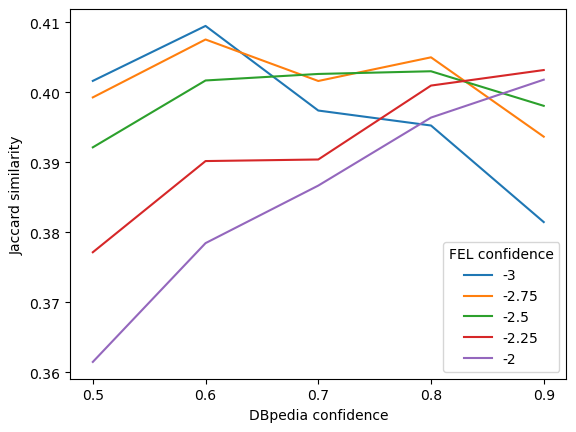

In [8]:
def jaccard_similarity(list1, list2):
    intersection = len(list(set(list1).intersection(list2)))
    union = (len(set(list1)) + len(set(list2))) - intersection
    return float(intersection) / union

all_sims = []
for fel_conf in ['3', '2.75', '2.5', '2.25', '2']:
    fel_entities = list(fel_full_graphs[fel_conf][1][0].values())
    node_similarity = []
    for conf in db_full_graphs:
        db_entities = list(db_full_graphs[conf][1][0].values())
        node_similarity.append(jaccard_similarity(fel_entities, db_entities))
    all_sims.append([fel_conf, node_similarity])

for sim_vals in all_sims:
    plt.plot(db_full_graphs.keys(), sim_vals[1], label = '-' + sim_vals[0])
plt.xlabel('DBpedia confidence')
plt.ylabel('Jaccard similarity')
plt.legend(title = 'FEL confidence')

In [9]:
db_values = list(db_full_graphs['0.5'][1][0].keys())
fel_values = list(fel_full_graphs['3'][1][0].keys())

overlap = set(fel_values) & set(db_values)

print('Total FEL entities: ' + str(len(fel_values)))
print('Total DB entities: ' + str(len(db_values)))
print('Overlap: ' + str(len(overlap)) + ' (' + str(len(overlap)/len(fel_values)) + ' of FEL entities)')

Total FEL entities: 535572
Total DB entities: 515022
Overlap: 322756 (0.6026379273001576 of FEL entities)


### Full Graphs Properties

In [10]:
index = ['num nodes', 'num edges', 'pseudo diameter', 'average degree', 'average weighted degree', 'largest component']

In [11]:
fel_main_prop_df = pd.DataFrame(columns = index)
for graph in fel_full_graphs:
    fel_main_prop_df = pd.concat([fel_main_prop_df, pd.Series(get_main_graph_prop(fel_full_graphs[graph][0]), index=index).to_frame().T], axis = 0)
fel_main_prop_df['conf'] = fel_full_graphs.keys()
fel_main_prop_df['conf'] = fel_main_prop_df['conf'].apply(lambda x: -float(x))

In [12]:
db_main_prop_df = pd.DataFrame(columns = index)
for graph in db_full_graphs:
    db_main_prop_df = pd.concat([db_main_prop_df, pd.Series(get_main_graph_prop(db_full_graphs[graph][0]), index=index).to_frame().T], axis = 0)
db_main_prop_df['conf'] = db_full_graphs.keys()

In [13]:
fel_main_prop_df['perc_largest_comp'] = fel_main_prop_df['largest component']/fel_main_prop_df['num nodes']
db_main_prop_df['perc_largest_comp'] = db_main_prop_df['largest component']/db_main_prop_df['num nodes']

In [14]:
cols = fel_main_prop_df.columns.tolist()
cols = cols[-1:] + cols[:-1]
fel_main_prop_df = fel_main_prop_df[cols]

fel_main_prop_df = fel_main_prop_df.iloc[::-1]

cols = db_main_prop_df.columns.tolist()
cols = cols[-1:] + cols[:-1]
db_main_prop_df = db_main_prop_df[cols]

In [15]:
fel_main_prop_df

,perc_largest_comp,num nodes,num edges,pseudo diameter,average degree,average weighted degree,largest component,conf
0,0.912120,535572.0,10019969.0,9.0,18.708911,93.087906,488506.0,-3.00
0,0.890213,496670.0,7539889.0,10.0,15.180883,75.774542,442142.0,-2.75
0,0.860775,456268.0,5496269.0,10.0,12.046142,60.685921,392744.0,-2.50
0,0.820077,409826.0,3846504.0,11.0,9.385700,46.826609,336089.0,-2.25
0,0.777433,357385.0,2594176.0,12.0,7.258771,36.581893,277843.0,-2.00


In [16]:
db_main_prop_df

,perc_largest_comp,num nodes,num edges,pseudo diameter,average degree,average weighted degree,largest component,conf
0,0.981174,515022.0,14113950.0,6.0,27.404557,240.852954,505326.0,0.5
0,0.971591,473225.0,8975858.0,6.0,18.967421,175.568362,459781.0,0.6
0,0.886125,435409.0,5855384.0,9.0,13.448009,76.201861,385827.0,0.7
0,0.854251,401286.0,4176344.0,9.0,10.407400,57.616184,342799.0,0.8
0,0.816466,358632.0,2920492.0,10.0,8.143423,44.245739,292811.0,0.9


### Full Graphs Plots

In [17]:
joint_conf_list = ['-3 / 0.5', '-2.75 / 0.6', '-2.5 / 0.7', '-2.25 / 0.8', '-2.00 / 0.9']

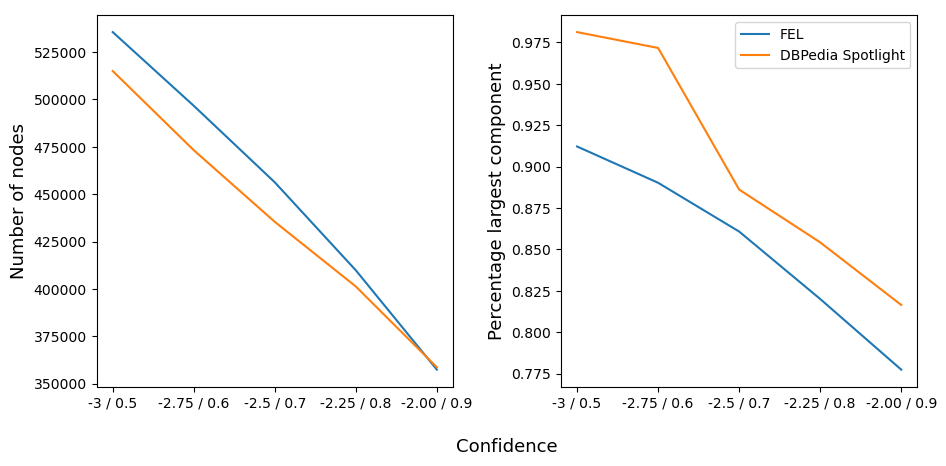

In [18]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)    
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)


ax1.plot(joint_conf_list, fel_main_prop_df['num nodes'], label = 'FEL')
ax1.plot(joint_conf_list, db_main_prop_df['num nodes'], label = 'DBPedia Spotlight')
#axs[0].ylabel('fds')

ax2.plot(joint_conf_list, fel_main_prop_df['perc_largest_comp'], label = 'FEL')
ax2.plot(joint_conf_list, db_main_prop_df['perc_largest_comp'], label = 'DBPedia Spotlight')
ax2.legend()

ax1.set_ylabel("Number of nodes", fontsize = 13)
ax2.set_ylabel("Percentage largest component", fontsize = 13)
ax.set_xlabel('Confidence', fontsize = 13, labelpad = 20)
fig.tight_layout()

### Connected Graphs Properties

In [19]:
fel_conn_prop_df = pd.DataFrame(columns = index)
for graph in fel_conn_graphs:
    fel_conn_prop_df = pd.concat([fel_conn_prop_df, pd.Series(get_main_graph_prop(fel_conn_graphs[graph][0]), index=index).to_frame().T], axis = 0)
fel_conn_prop_df['conf'] = fel_conn_graphs.keys()
fel_conn_prop_df['conf'] = fel_conn_prop_df['conf'].apply(lambda x: -float(x))

In [20]:
db_conn_prop_df = pd.DataFrame(columns = index)
for graph in db_conn_graphs:
    db_conn_prop_df = pd.concat([db_conn_prop_df, pd.Series(get_main_graph_prop(db_conn_graphs[graph][0]), index=index).to_frame().T], axis = 0)
db_conn_prop_df['conf'] = db_conn_graphs.keys()

In [21]:
cols = fel_conn_prop_df.columns.tolist()
cols = cols[-1:] + cols[:-1]
fel_conn_prop_df = fel_conn_prop_df[cols]

fel_conn_prop_df = fel_conn_prop_df.iloc[::-1]

cols = db_conn_prop_df.columns.tolist()
cols = cols[-1:] + cols[:-1]
db_conn_prop_df = db_conn_prop_df[cols]

In [22]:
fel_conn_prop_df

,conf,num nodes,num edges,pseudo diameter,average degree,average weighted degree,largest component
0,-3.00,488506.0,10017512.0,9.0,20.506426,102.046132,488506.0
0,-2.75,442142.0,7536960.0,10.0,17.046469,85.105695,442142.0
0,-2.50,392744.0,5492703.0,10.0,13.985454,70.482543,392744.0
0,-2.25,336089.0,3842187.0,11.0,11.432052,57.073323,336089.0
0,-2.00,277843.0,2589306.0,12.0,9.319313,47.017891,277843.0


In [23]:
db_conn_prop_df

,conf,num nodes,num edges,pseudo diameter,average degree,average weighted degree,largest component
0,0.5,505326.0,14113714.0,6.0,27.929919,245.473405,505326.0
0,0.6,459781.0,8975501.0,6.0,19.521253,180.700420,459781.0
0,0.7,385827.0,5853024.0,9.0,15.170074,85.981557,385827.0
0,0.8,342799.0,4173397.0,9.0,12.174473,67.428236,342799.0
0,0.9,292811.0,2917002.0,10.0,9.962064,54.166421,292811.0


### Connected Graphs Plots

In [24]:
fel_conn_prop_df['scaled average degree'] = fel_conn_prop_df['average degree']/fel_conn_prop_df['num nodes']
fel_conn_prop_df['scaled average weighted degree'] = fel_conn_prop_df['average weighted degree']/fel_conn_prop_df['num nodes']

db_conn_prop_df['scaled average degree'] = db_conn_prop_df['average degree']/db_conn_prop_df['num nodes']
db_conn_prop_df['scaled average weighted degree'] = db_conn_prop_df['average weighted degree']/db_conn_prop_df['num nodes']

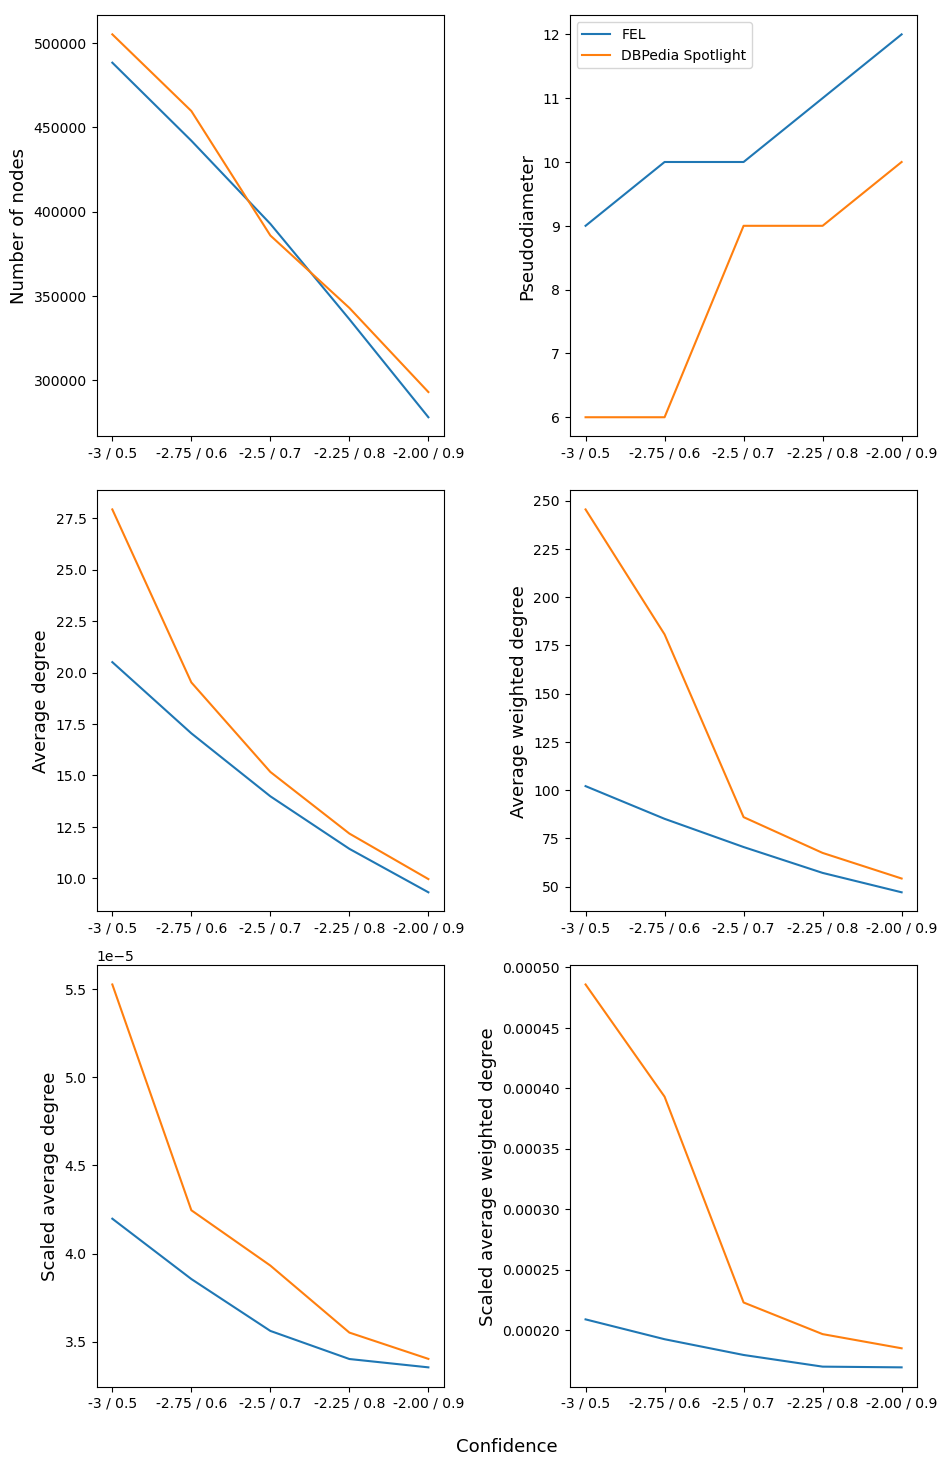

In [25]:
fig = plt.figure(figsize=(10,15))
ax = fig.add_subplot(111) 
ax1 = fig.add_subplot(321)
ax2 = fig.add_subplot(322)
ax3 = fig.add_subplot(323)
ax4 = fig.add_subplot(324)
ax5 = fig.add_subplot(325)
ax6 = fig.add_subplot(326)

ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)


ax1.plot(joint_conf_list, fel_conn_prop_df['num nodes'], label = 'FEL')
ax1.plot(joint_conf_list, db_conn_prop_df['num nodes'], label = 'DBPedia Spotlight')
#axs[0].ylabel('fds')

ax2.plot(joint_conf_list, fel_conn_prop_df['pseudo diameter'], label = 'FEL')
ax2.plot(joint_conf_list, db_conn_prop_df['pseudo diameter'], label = 'DBPedia Spotlight')
ax2.legend()

ax3.plot(joint_conf_list, fel_conn_prop_df['average degree'], label = 'FEL')
ax3.plot(joint_conf_list, db_conn_prop_df['average degree'], label = 'DBPedia Spotlight')
#axs[0].ylabel('fds')

ax4.plot(joint_conf_list, fel_conn_prop_df['average weighted degree'], label = 'FEL')
ax4.plot(joint_conf_list, db_conn_prop_df['average weighted degree'], label = 'DBPedia Spotlight')

ax5.plot(joint_conf_list, fel_conn_prop_df['scaled average degree'], label = 'FEL')
ax5.plot(joint_conf_list, db_conn_prop_df['scaled average degree'], label = 'DBPedia Spotlight')
#axs[0].ylabel('fds')

ax6.plot(joint_conf_list, fel_conn_prop_df['scaled average weighted degree'], label = 'FEL')
ax6.plot(joint_conf_list, db_conn_prop_df['scaled average weighted degree'], label = 'DBPedia Spotlight')

ax1.set_ylabel("Number of nodes", fontsize = 13)
ax2.set_ylabel("Pseudodiameter", fontsize = 13)
ax3.set_ylabel("Average degree", fontsize = 13)
ax4.set_ylabel("Average weighted degree", fontsize = 13)
ax5.set_ylabel("Scaled average degree", fontsize = 13)
ax6.set_ylabel("Scaled average weighted degree", fontsize = 13)

ax.set_xlabel('Confidence', fontsize = 13, labelpad = 20)
fig.tight_layout()

Text(0.5, 1.0, 'DBPedia Spotlight')

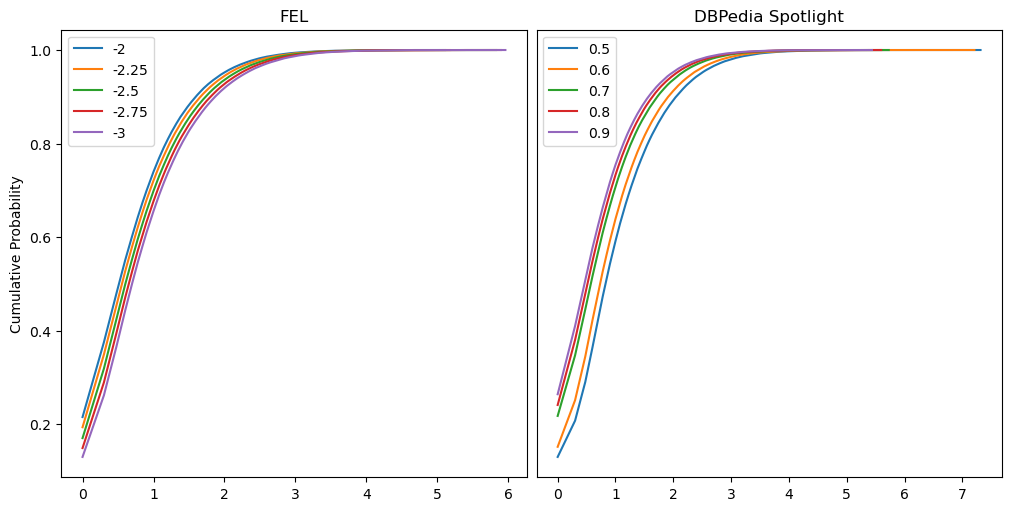

In [26]:
fig, axs = plt.subplots(1, 2, layout='constrained', figsize=(10, 5))

for conf in fel_conn_graphs:
    plot_log_deg_dist(fel_conn_graphs[conf][0], axs[0], weighted = True, label = '-' + conf)

axs[0].set_ylabel('Cumulative Probability')
axs[0].legend()
axs[0].set_title('FEL')

for conf in db_conn_graphs:
    plot_log_deg_dist(db_conn_graphs[conf][0], axs[1], weighted = True, label = conf)

axs[1].set_yticks([])
axs[1].legend()
axs[1].set_title('DBPedia Spotlight')

In [27]:
index = ['ave local clust', 'ave global clust', 'weighted assort', 'unweighted assort']

def create_ave_prop_df(conn_graphs_dict):
    ave_prop_df = pd.DataFrame(columns = index)
    
    for graph in conn_graphs_dict:
        ave_prop_df = pd.concat([ave_prop_df, pd.Series(calc_ave_graph_values(conn_graphs_dict[graph][0]), index=index).to_frame().T], axis = 0)
    ave_prop_df['graph'] = conn_graphs_dict.keys()
    
    ave_prop_df['ave local clust val'] =ave_prop_df['ave local clust'].apply(lambda x: x[0])
    ave_prop_df['ave global clust val'] =ave_prop_df['ave global clust'].apply(lambda x: x[0])
    ave_prop_df['weighted assort val'] =ave_prop_df['weighted assort'].apply(lambda x: x[0])
    ave_prop_df['unweighted assort val'] =ave_prop_df['unweighted assort'].apply(lambda x: x[0])

    return ave_prop_df

In [29]:
fel_ave_prop_df = create_ave_prop_df(fel_conn_graphs)
db_ave_prop_df = create_ave_prop_df(db_conn_graphs)

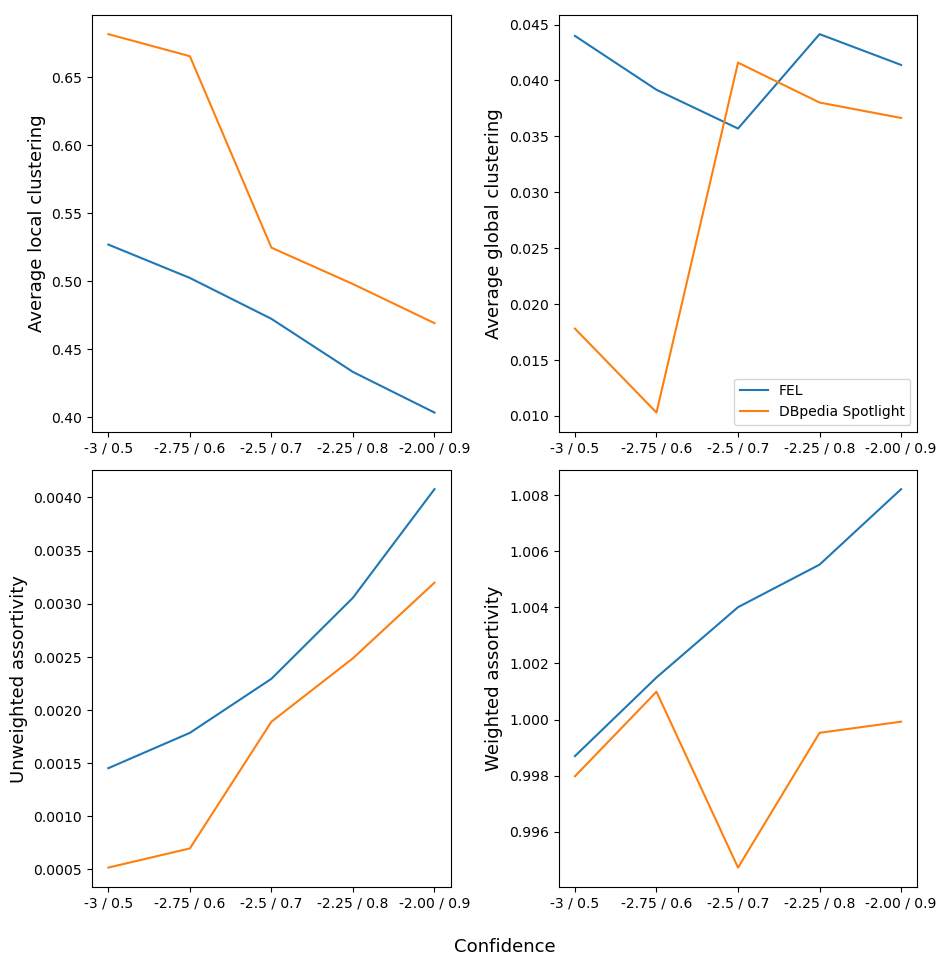

In [30]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)   
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)


ax1.plot(joint_conf_list, fel_ave_prop_df['ave local clust val'][::-1], label = 'FEL')
ax1.plot(joint_conf_list, db_ave_prop_df['ave local clust val'], label = 'DBpedia Spotlight')
#axs[0].ylabel('fds')

ax2.plot(joint_conf_list, fel_ave_prop_df['ave global clust val'][::-1], label = 'FEL')
ax2.plot(joint_conf_list, db_ave_prop_df['ave global clust val'], label = 'DBpedia Spotlight')
ax2.legend()

ax3.plot(joint_conf_list, fel_ave_prop_df['unweighted assort val'][::-1], label = 'FEL')
ax3.plot(joint_conf_list, db_ave_prop_df['unweighted assort val'], label = 'DBpedia Spotlight')
#axs[0].ylabel('fds')

ax4.plot(joint_conf_list, fel_ave_prop_df['weighted assort val'][::-1], label = 'FEL')
ax4.plot(joint_conf_list, db_ave_prop_df['weighted assort val'], label = 'DBpedia Spotlight')

ax1.set_ylabel("Average local clustering", fontsize = 13)
ax2.set_ylabel("Average global clustering", fontsize = 13)
ax3.set_ylabel("Unweighted assortivity", fontsize = 13)
ax4.set_ylabel("Weighted assortivity", fontsize = 13)

ax.set_xlabel('Confidence', fontsize = 13, labelpad = 20)
fig.tight_layout()

### Top Edges

In [31]:
fel_top_edges_df = pd.DataFrame()
for conf in fel_conn_graphs:
    top_edges = get_top_edges(fel_conn_graphs[conf][0],fel_conn_graphs[conf][1], 10)
    fel_top_edges_df['-' + conf] = top_edges[::-1]

In [32]:
cols = fel_top_edges_df.columns.tolist()
cols = cols[::-1]
fel_top_edges_df = fel_top_edges_df[cols]

In [33]:
fel_top_edges_df

,-3,-2.75,-2.5,-2.25,-2
0,"(MTV, BTS)","(MTV, BTS)","(MTV, BTS)","(MTV, BTS)","(MTV, BTS)"
1,"(Pfizer, Moderna)","(Bachelor_of_Science, D%C3%A9FI)","(Bachelor_of_Science, D%C3%A9FI)","(Metaverse, Non-fungible_token)","(Non-fungible_token, Metaverse)"
2,"(Ministry_of_Health_and_Family_Welfare, India)","(Whitelist, Bachelor_of_Science)","(Whitelist, Bachelor_of_Science)","(Jimin, BTS)","(Jimin, BTS)"
3,"(Bachelor_of_Science, D%C3%A9FI)","(Whitelist, D%C3%A9FI)","(Whitelist, D%C3%A9FI)","(Non-fungible_token, Bachelor_of_Science)","(YouTube, Spotify)"
4,"(Bachelor_of_Science, Whitelist)","(Riaz_%28actor%29, Umar)","(Jungkook, BTS)","(Mandalay, Military_dictatorship)","(Jungkook, BTS)"
5,"(Reblogging, Twitter)","(Metaverse, Non-fungible_token)","(Metaverse, Non-fungible_token)","(Spotify, YouTube)","(Netflix, Spotify)"
6,"(D%C3%A9FI, Launchpad_%28website%29)","(Bachelor_of_Science, Non-fungible_token)","(Discord, Non-fungible_token)","(BTS, Jungkook)","(Netflix, Viu_%28streaming_service%29)"
7,"(Bachelor_of_Science, Launchpad_%28website%29)","(Discord, Non-fungible_token)","(China, COVID-19)","(Netflix, Spotify)","(Spotify, Viu_%28streaming_service%29)"
8,"(D%C3%A9FI, Whitelist)","(Jungkook, BTS)","(Jimin, BTS)","(Netflix, Viu_%28streaming_service%29)","(Non-fungible_token, MetaMask)"
9,"(Umar, Riaz_%28actor%29)","(Military_dictatorship, Mandalay)","(Bachelor_of_Science, Non-fungible_token)","(Spotify, Viu_%28streaming_service%29)","(Non-fungible_token, OpenSea)"


In [34]:
db_top_edges_df = pd.DataFrame()
for conf in db_conn_graphs:
    top_edges = get_top_edges(db_conn_graphs[conf][0],db_conn_graphs[conf][1], 10)
    db_top_edges_df[conf] = top_edges[::-1]

In [35]:
db_top_edges_df

,0.5,0.6,0.7,0.8,0.9
0,"(COVID-19_pandemic, Twitter)","(Twitter, COVID-19_pandemic)","(Radiotelephone, Lady_Gaga)","(BTS, MTV)","(MTV, BTS)"
1,"(Twitter, COVID-19_vaccine)","(Twitter, COVID-19_vaccine)","(MTV, BTS)","(COVID-19_vaccine, Pfizer)","(COVID-19_vaccine, Pfizer)"
2,"(Twitter, Coronavirus)","(Coronavirus, Twitter)","(COVID-19_vaccine, Pfizer)","(Pfizer, Moderna_COVID-19_vaccine)","(Test_cricket, India_national_cricket_team)"
3,"(Twitter, COVID-19_lockdowns)","(Twitter, COVID-19)","(Virus, Vaccine)","(Test_cricket, India_national_cricket_team)","(COVID-19_vaccine, AstraZeneca)"
4,"(Twitter, COVID-19)","(Test_cricket, Twitter)","(Moderna_COVID-19_vaccine, Pfizer)","(Russia, Ukraine)","(COVID-19_pandemic_in_mainland_China, Wuhan)"
5,"(Quarantine, Twitter)","(Twitter, President_of_the_United_States)","(Test_cricket, India_national_cricket_team)","(Wuhan, COVID-19_pandemic_in_mainland_China)","(Pfizer, Moderna_COVID-19_vaccine)"
6,"(Twitter, Test_cricket)","(YouTube, Twitter)","(Ukraine, Russia)","(COVID-19_vaccine, COVID-19)","(Ukraine, Russia)"
7,"(United_Kingdom, Twitter)","(Virus, Twitter)","(COVID-19_vaccine, COVID-19)","(Narendra_Modi, India)","(United_States, Mandalay)"
8,"(Twitter, Virus)","(India, Twitter)","(Wuhan, COVID-19_pandemic_in_mainland_China)","(Vaccine, Immune_system)","(India, Narendra_Modi)"
9,"(Twitter, India)","(Twitter, Radiotelephone)","(India, Narendra_Modi)","(United_States, Mandalay)","(COVID-19_vaccine, COVID-19)"


### Top Nodes

In [36]:
fel_top_weighted_df = pd.DataFrame()
fel_top_unweighted_df = pd.DataFrame()
for conf in fel_conn_graphs:
    top_nodes = get_top_degree_nodes(fel_conn_graphs[conf][0],fel_conn_graphs[conf][1], 20)
    fel_top_weighted_df['-' + conf] = list(top_nodes[0].keys())
    fel_top_unweighted_df['-' + conf] = list(top_nodes[1].keys())

In [37]:
cols = fel_top_weighted_df.columns.tolist()
cols = cols[::-1]
fel_top_weighted_df = fel_top_weighted_df[cols]

In [38]:
fel_top_weighted_df

,-3,-2.75,-2.5,-2.25,-2
0,COVID-19,COVID-19,COVID-19,YouTube,YouTube
1,Twitter,Quarantine,India,India,India
2,Quarantine,India,YouTube,BTS,BTS
3,India,Midfielder,Twitter,China,Midfielder
4,Midfielder,YouTube,BTS,Midfielder,Twitter
5,Vaccination,Twitter,China,Twitter,Spotify
6,YouTube,Non-fungible_token,Midfielder,Non-fungible_token,Non-fungible_token
7,Non-fungible_token,China,Non-fungible_token,Spotify,Netflix
8,China,BTS,Spotify,Reblogging,Pfizer
9,BTS,Bachelor_of_Science,Bachelor_of_Science,Pfizer,MTV


In [39]:
db_top_weighted_df = pd.DataFrame()
db_top_unweighted_df = pd.DataFrame()
for conf in db_conn_graphs:
    top_nodes = get_top_degree_nodes(db_conn_graphs[conf][0],db_conn_graphs[conf][1], 20)
    db_top_weighted_df[conf] = list(top_nodes[0].keys())
    db_top_unweighted_df[conf] = list(top_nodes[1].keys())

In [40]:
db_top_weighted_df

,0.5,0.6,0.7,0.8,0.9
0,Twitter,Twitter,COVID-19_vaccine,COVID-19_vaccine,COVID-19_vaccine
1,COVID-19_pandemic,COVID-19_pandemic,COVID-19_pandemic,COVID-19_pandemic,Test_cricket
2,COVID-19_vaccine,COVID-19_vaccine,COVID-19,Test_cricket,COVID-19
3,COVID-19,Coronavirus,Virus,COVID-19,Pfizer
4,Coronavirus,COVID-19,Test_cricket,Vaccine,COVID-19_pandemic
5,COVID-19_lockdowns,Virus,Vaccine,Pfizer,Vaccine
6,Virus,President_of_the_United_States,India,India,BTS
7,United_Kingdom,Test_cricket,Pfizer,China,Twitter
8,Quarantine,Vaccine,China,Twitter,YouTube
9,India,India,Radiotelephone,YouTube,India
